<a href="https://colab.research.google.com/github/leandroleao2k/ImageML/blob/main/PCA%20Reducao%20Dimensionalidade.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#GMM Gaussian Mixture Model
GMM vai agrupar os padroes de acordo com a distribuição normal (Gauss) que ele encontrar nos dados. Com isso os clusters pondem até se sobrepor instancias, ou seja, elementos pondem ter uma probabilidade de estar em um cluster ou outro
https://scikit-learn.org/stable/modules/mixture.html
Vamos usar Expectation Maximization EM para definir os melhores parametros 

In [16]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.patches import Ellipse

from sklearn.mixture import GaussianMixture
from sklearn.datasets import make_moons
from sklearn.datasets import make_blobs

%matplotlib inline
sns.set(style='darkgrid', context='talk', rc={'figure.figsize': (20, 5)})

# cria base de dados
X , y = make_blobs ( n_samples=1000, centers=7, n_features=2, random_state=303)
df = pd.DataFrame(X, columns=['x','y'])
df['label'] = y
df.head()

,x,y,label
0,3.142882,-5.958110,5
1,-0.151735,-0.992617,2
2,-0.864490,7.808697,1
3,-0.513696,7.735088,1
4,6.539781,-3.980419,0


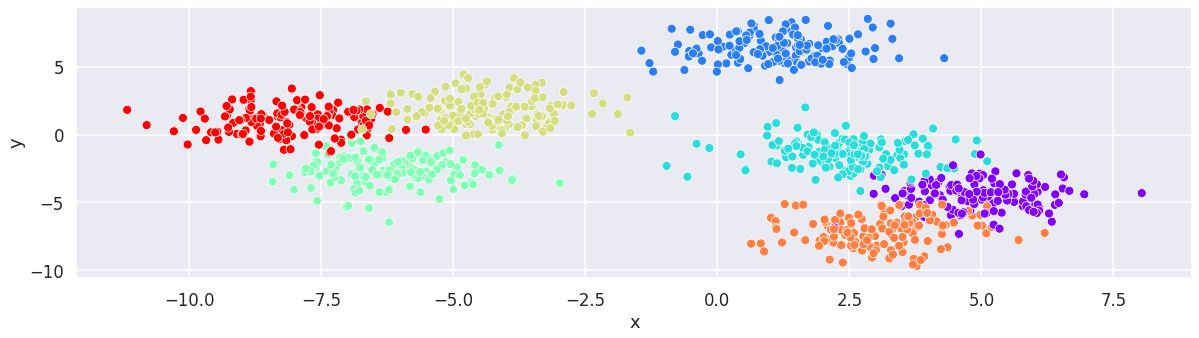

In [17]:
_ = sns.scatterplot(x='x', y='y', data=df, hue='label', palette='rainbow', legend=False)

# Cria Funcao para treinar GMM e plotar:
https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html

In [18]:
def treinar_plotar_gmm(data, k=3, covariance_type='full', tol=0.001, max_iter=100, n_init=1, init_params='kmeans', random_state=133):
  data_cp = data.copy()
  data_cp.drop (columns='label',inplace = True)

  model = GaussianMixture(n_components=k,covariance_type=covariance_type, tol=tol, max_iter=max_iter, n_init=n_init, 
                          init_params=init_params, random_state=random_state)
  model.fit(data_cp)
  data_cp['cluster_labels'] = model.predict(data_cp)
  _ = sns.scatterplot(x='x', y='y', data=data_cp, hue='cluster_labels', palette='rainbow', legend=False)
  
  means = model.means_
  means_x = means[:,0]
  means_y = means[:,1]
  _ = plt.scatter(means_x, means_y, color='black', s=100)
  w_factor = 0.2 / model.weights_.max()

  if covariance_type == 'tied':
    covars = np.repeat(model.covariances_, k, axis=0)
  else:
    covars = model.covariances_

  for pos, covar, w in zip(model.means_, model.covariances_, model.weights_):
        draw_ellipse(pos, covar, covariance_type,alpha=w * w_factor)

  return model

def draw_ellipse(position, covariance, covariance_type, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))

def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covariance, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covariance, 'tied',alpha=w * w_factor)

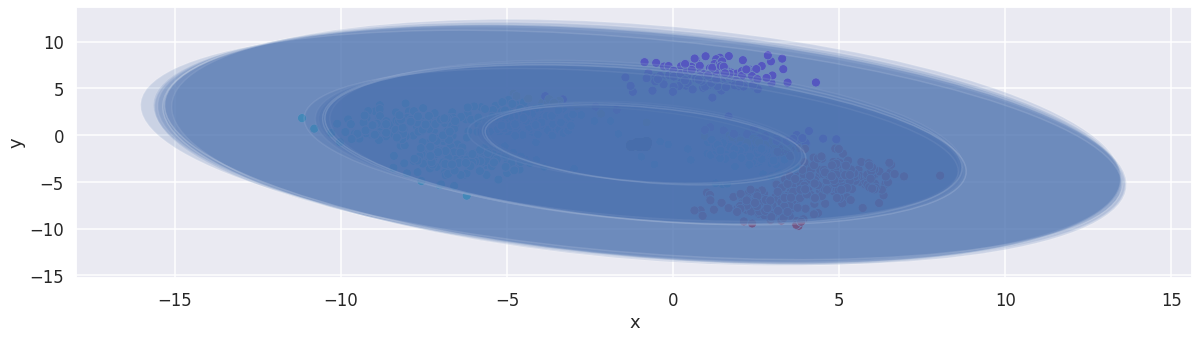

In [19]:
gmm = treinar_plotar_gmm (df, k=7, random_state=4000, init_params='random')

## Testar uma base de dados torcida

In [20]:
transformation = [[0.3,-0.3], [-1.2,0.2]]
X , y = make_blobs ( n_samples=1000, centers=7, n_features=2, random_state=170)
df_trans = pd.DataFrame(np.dot(X,transformation), columns=['x','y'])
df_trans['label'] = y
df_trans.head()

,x,y,label
0,3.775776,-2.551136,4
1,4.798597,-1.459384,5
2,3.910070,1.590275,0
3,5.554648,1.009466,0
4,-10.997360,2.443557,6


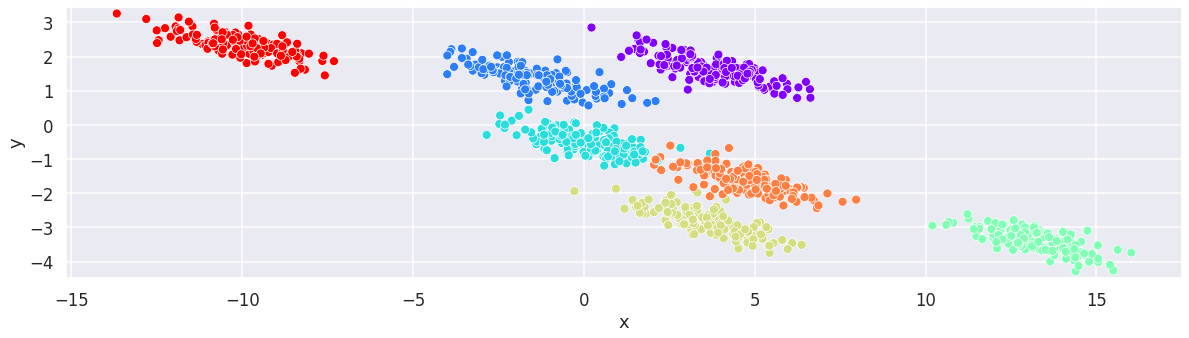

In [21]:
ax = sns.scatterplot(x='x', y='y', data=df_trans, hue='label', palette='rainbow', legend=False)
_ = ax.axis('equal')

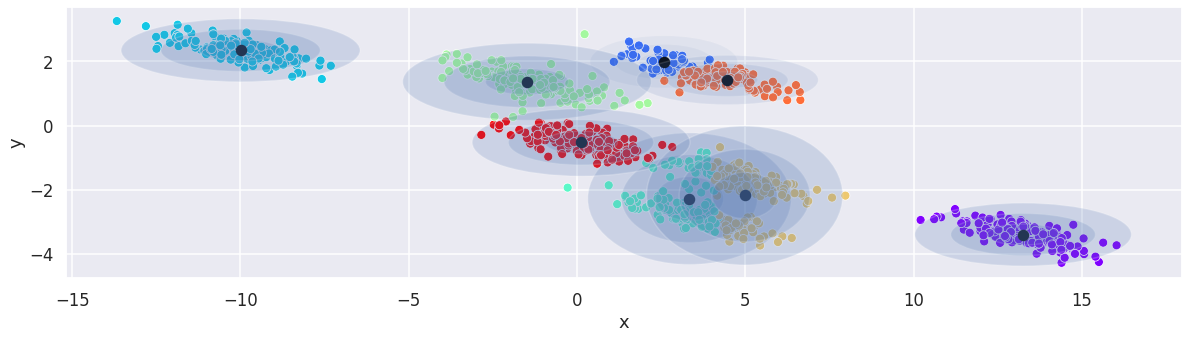

In [22]:
gmm = treinar_plotar_gmm (df_trans, k=8, covariance_type = 'diag', max_iter = 1000, random_state=4000, init_params='kmeans')

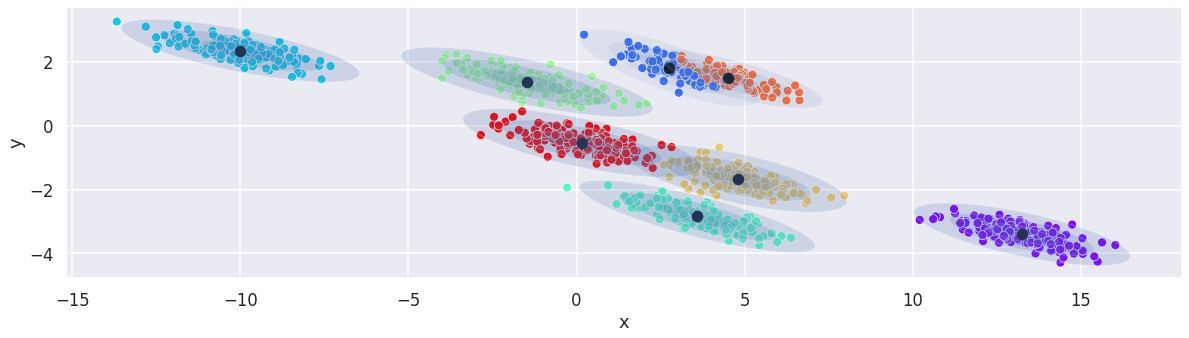

In [23]:
gmm = treinar_plotar_gmm (df_trans, k=8, covariance_type = 'full', max_iter = 1000, random_state=4000, init_params='kmeans')

# Método Cotovelo (Elbow)
### Estudo para achar o nro maximo de Clusters usando o Kmeans

In [24]:
from sklearn.cluster import KMeans
def do_elbow_plot(dataframe, max_clusters):
  min_clusters=1
  clusters_range = range(min_clusters, max_clusters+1)
  inertias = []
  for k in clusters_range:
    model = KMeans(n_clusters=k, random_state=33)
    model.fit(dataframe)

    cur_inertia = model.inertia_
    inertias.append(cur_inertia)

  _ = plt.plot(clusters_range, inertias, '-o')
  _ = plt.title('Metodo Cotovelo para achar Max Clusters')
  _ = plt.xlabel('# clusters')
  _ = plt.ylabel('Inercia')
  _ = plt.xticks(clusters_range)
  plt.show() 

#### Note que o cotovelo sugere a mudança na inercia para valores >2 e <=8 

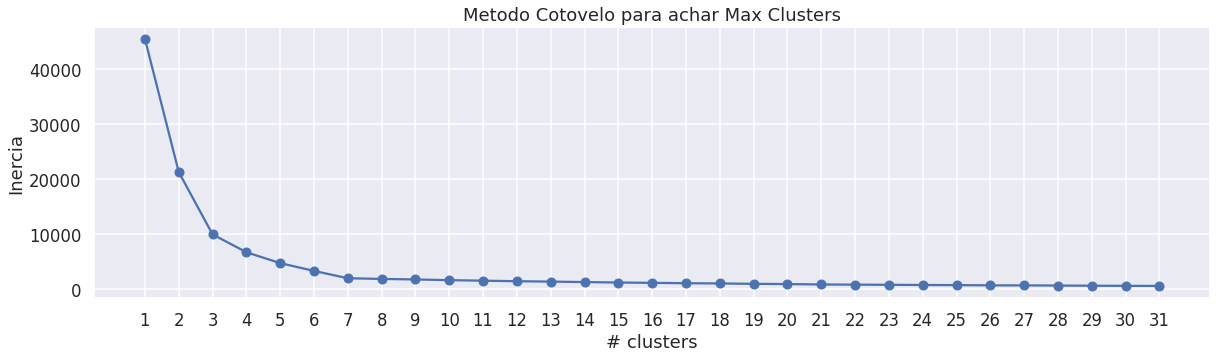

CPU times: user 5.8 s, sys: 49.3 ms, total: 5.85 s
Wall time: 3.23 s


In [25]:
%%time
do_elbow_plot(df, max_clusters=int(np.sqrt(len(df))))